In [153]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import PS5
import pandas as pd
import pickle
from scipy.optimize import curve_fit

In [150]:
try:
    with open("peaks1.pickle", "rb") as f:
        peaks, hist, bins = pickle.load(f)
except FileNotFoundError:
    channel_data = PS5.load_channel_data()
    values = channel_data.loc[1, "values"]
    hist, bins = PS5.normal_binify(values)
    peaks, _ = PS5.my_peaks(hist, bins, n=0)
    peaks = pd.DataFrame(peaks, columns=["center", "height", "std", "offset", "slope"])
    with open("peaks1.pickle", "wb") as f:
        pickle.dump((peaks, hist, bins), f)
bin_width = np.mean(bins[1:] - bins[:-1])

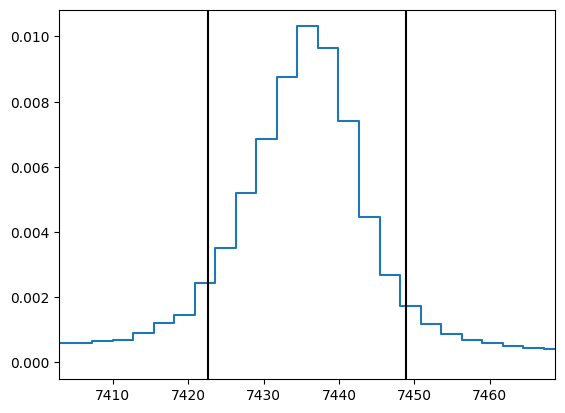

In [144]:
highest_peak = peaks.loc[peaks["height"].idxmax()]
left = highest_peak["center"] - 2 * highest_peak["std"]
right = highest_peak["center"] + 2 * highest_peak["std"]
plt.step(bins, hist, where="mid")
plt.xlim(
    highest_peak["center"] - 5 * highest_peak["std"],
    highest_peak["center"] + 5 * highest_peak["std"],
)
plt.axvline(left, color="black")
plt.axvline(right, color="black")

(array([ 771., 1175., 1545., 2011., 2445., 2687., 2255., 1565.,  986.,
         590.]),
 array([7422.64111328, 7425.27197266, 7427.90283203, 7430.53369141,
        7433.16455078, 7435.79492188, 7438.42578125, 7441.05664062,
        7443.6875    , 7446.31835938, 7448.94921875]),
 <BarContainer object of 10 artists>)

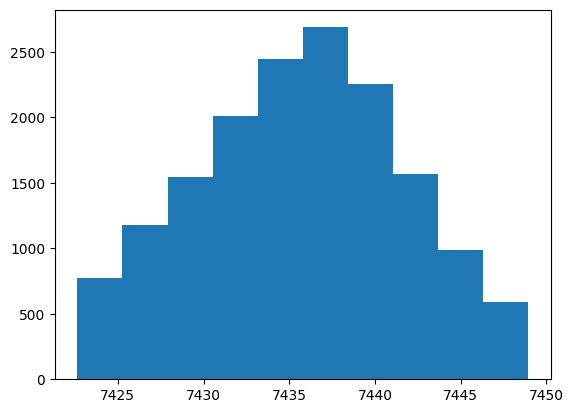

In [145]:
emask = (values > left) & (values < right)
plt.hist(values[emask])

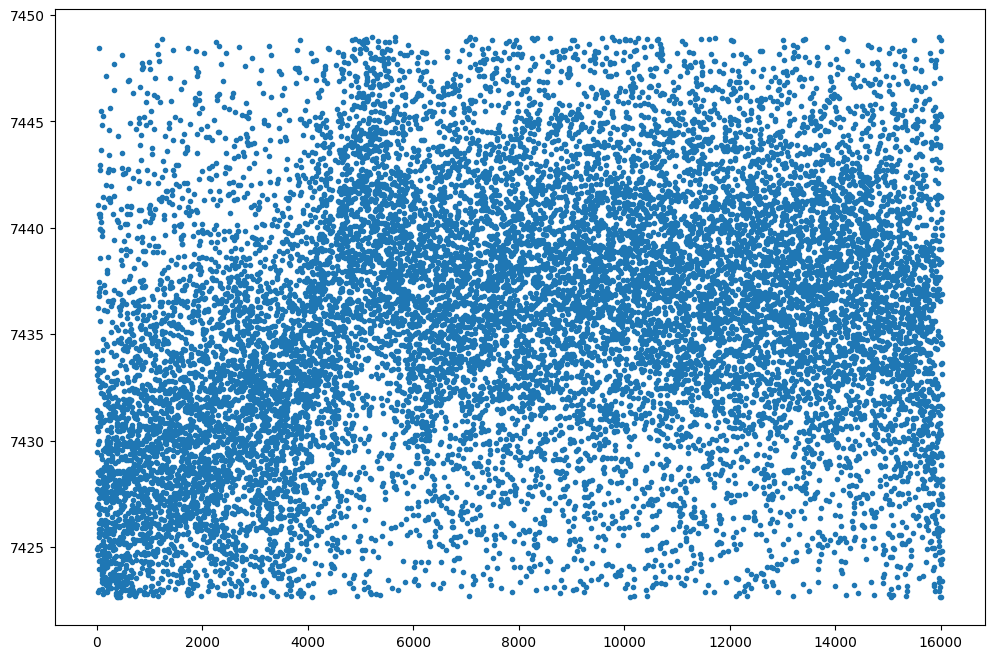

In [113]:
xs = np.arange(emask.sum())
in_peak_events = values[emask]
plt.scatter(xs, in_peak_events, marker=".")
plt.gca().figure.set_size_inches(12, 8)

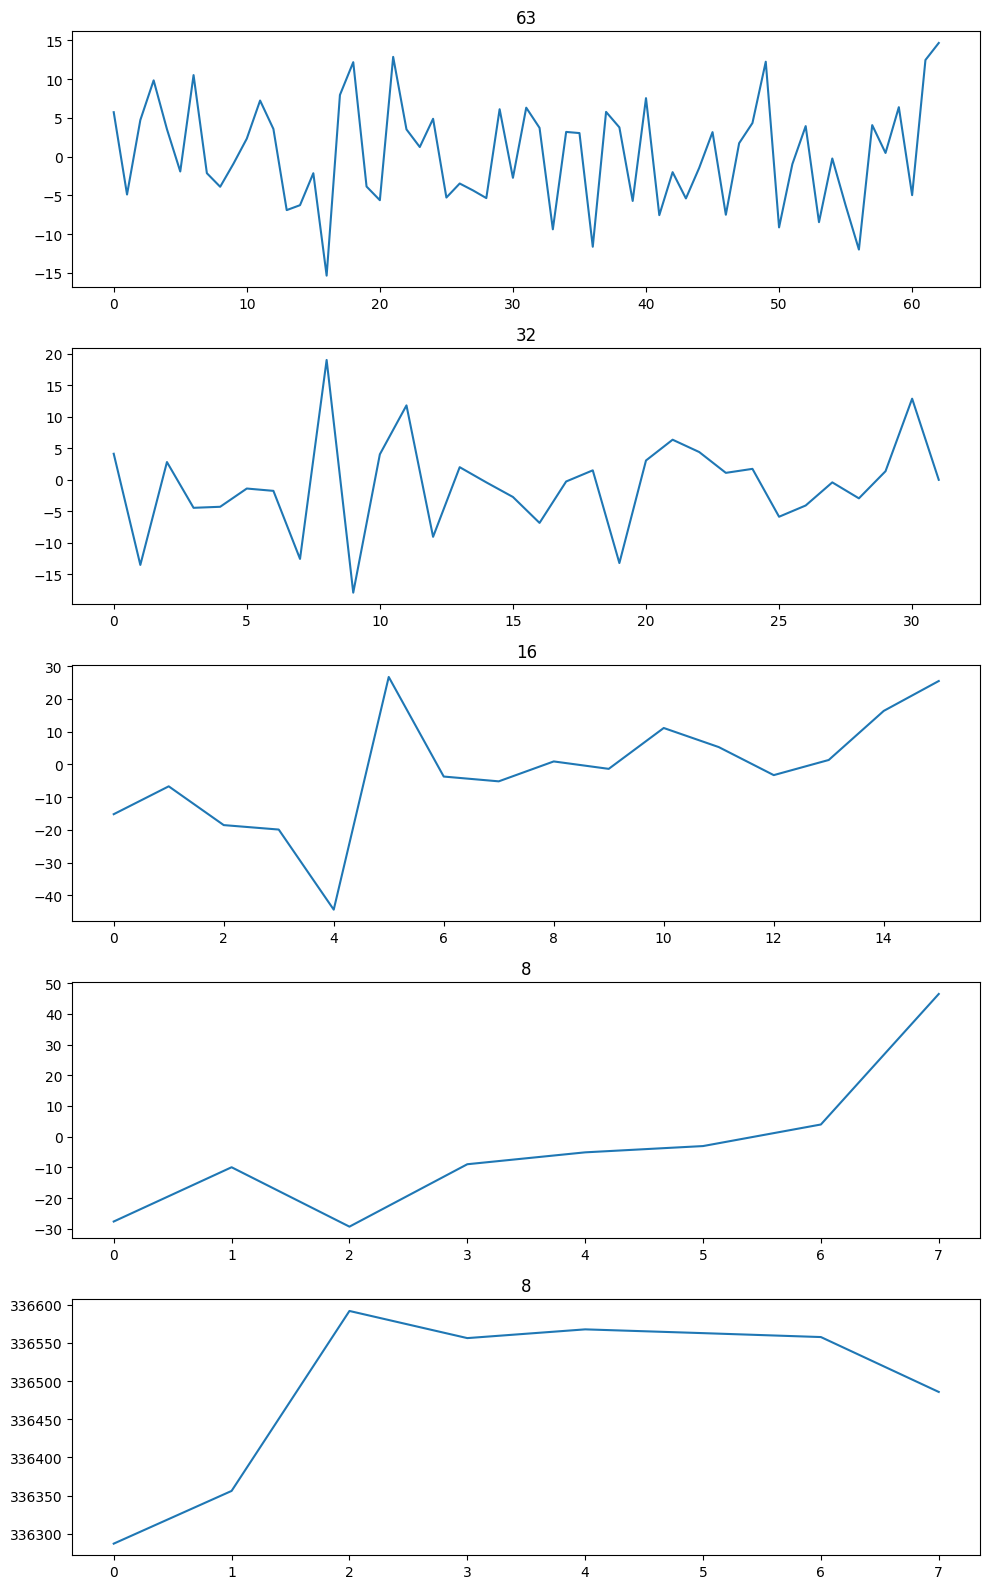

In [81]:
wavelet = "haar"
filter_bank = []
ca = in_peak_events
while len(ca) > 10:
    ca, cd = pywt.dwt(ca, wavelet)
    filter_bank.append(cd)
filter_bank.append(ca)
show = 5
fig, axes = plt.subplots(nrows=show)
for res, ax in zip(filter_bank[-show:], axes):
    ax.plot(res)
    ax.set_title(len(res))
fig.set_size_inches(10, 16)
fig.tight_layout()

In [85]:
[len(s) for s in filter_bank]

[8015, 4008, 2004, 1002, 501, 251, 126, 63, 32, 16, 8, 8]

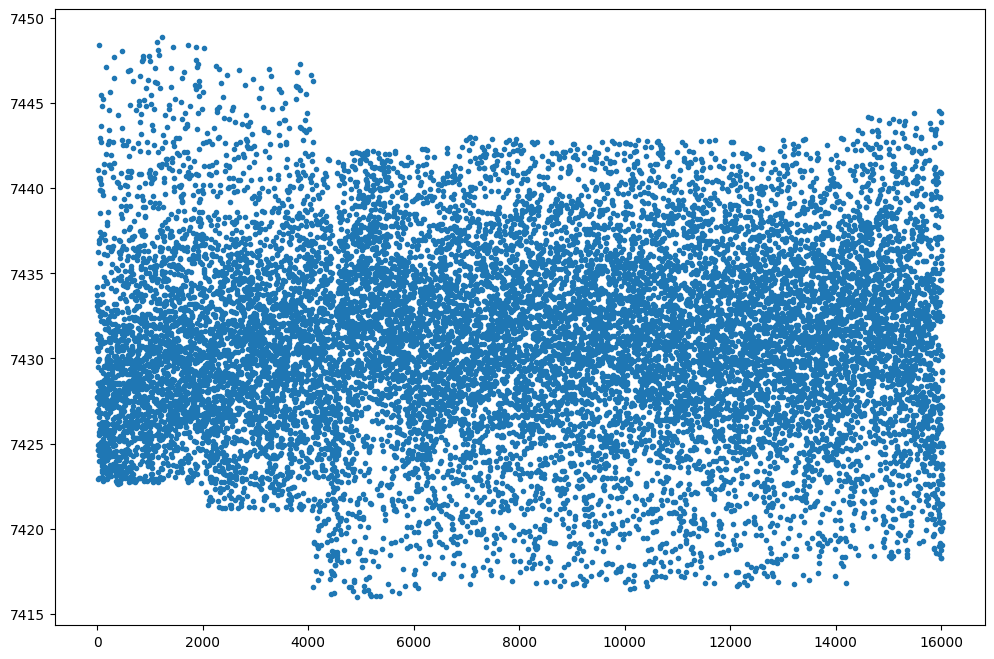

In [183]:
ca = filter_bank[-1]
ca = np.full(ca.shape, ca[0])
for i in range(len(filter_bank) - 2, -1, -1):
    cd = filter_bank[i]
    minlen = min(len(ca), len(cd))
    ca = pywt.idwt(ca[:minlen], cd[:minlen], wavelet)
corrected_in_peak_events = ca
in_peak_events = in_peak_events[: len(corrected_in_peak_events)]
plt.scatter(range(len(corrected_in_peak_events)), corrected_in_peak_events, marker=".")
plt.gca().figure.set_size_inches(12, 8)

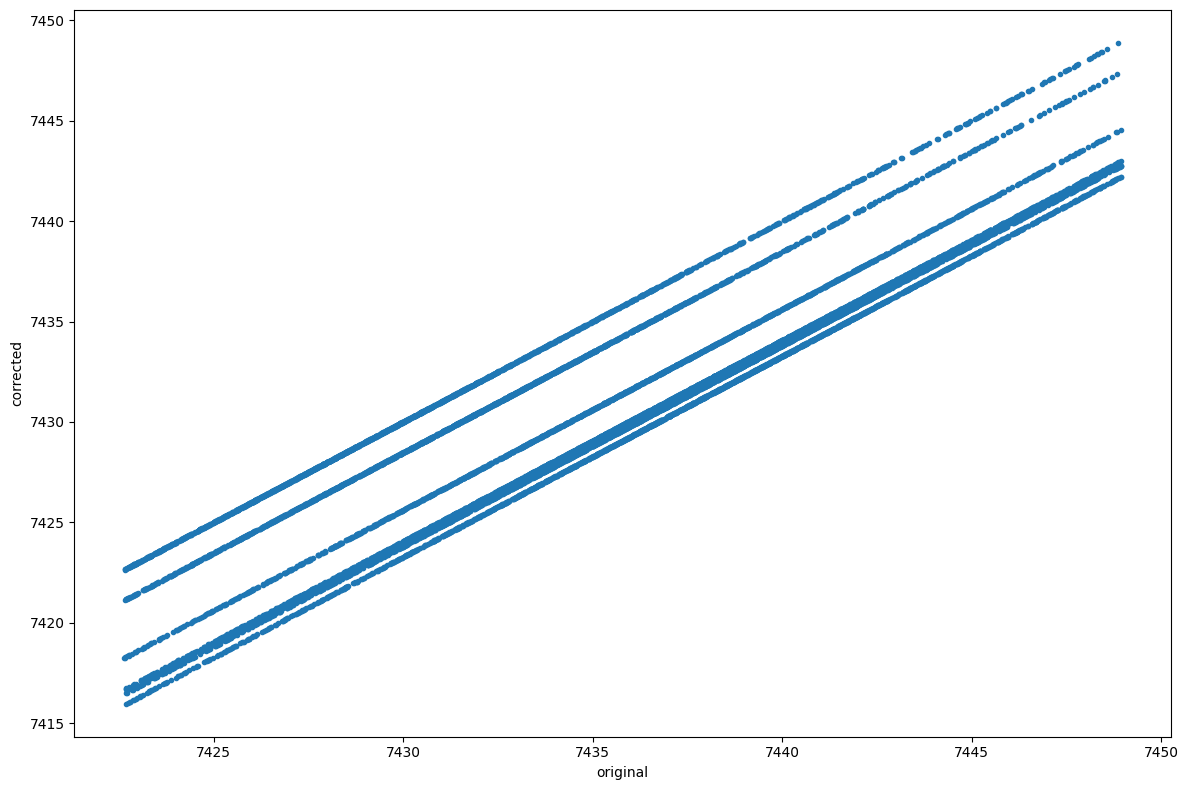

In [186]:
plt.scatter(x=in_peak_events, y=corrected_in_peak_events, marker=".")
n = min(in_peak_events.min(), corrected_in_peak_events.min())
x = max(in_peak_events.max(), corrected_in_peak_events.max())
ax = plt.gca()
ax.set_xlabel("original")
ax.set_ylabel("corrected")
ax.figure.set_size_inches(12, 8)
ax.figure.tight_layout();

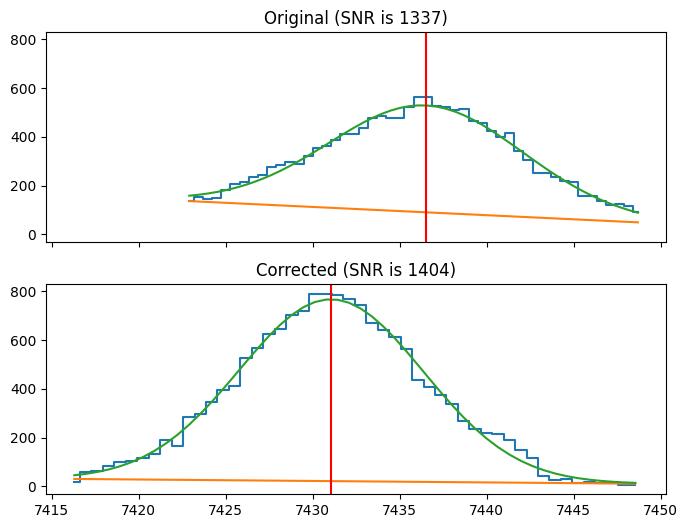

In [197]:
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
for events, title, ax in zip(
    [in_peak_events, corrected_in_peak_events], ["Original", "Corrected"], axes
):
    hist, ebins = np.histogram(events, bins=50)
    xs = (ebins[:-1] + ebins[1:]) / 2
    ax.step(xs, hist, where="mid")
    [center, height, std, offset, slope], _ = curve_fit(
        PS5.linear_guass,
        xs,
        hist,
        p0=[ebins.mean(), hist.max(), highest_peak.std(), 0, 1],
        bounds=(
            [ebins.min(), 0, 0, 0, -np.inf],
            [ebins.max(), hist.max(), np.inf, hist.max(), np.inf],
        ),
    )
    baseline = (xs - center) * slope + offset
    gaussian = np.e ** -((xs - center) ** 2 / (2 * std**2)) * height
    ax.plot(xs, baseline)
    ax.plot(xs, baseline + gaussian)
    ax.axvline(center, color="red")
    ax.set_title(title + f" (SNR is {int(center / std)})")

fig.set_size_inches(8, 6)